Missing values in the dataset:
feature1    96
feature2    93
feature3    95
label        0
dtype: int64

Decision Tree with Missing Values:
Cross-validation mean accuracy: 0.5162 (+/- 0.0630)
Training set accuracy: 0.9912
Test set accuracy: 0.5500

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        97
           1       0.56      0.58      0.57       103

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200



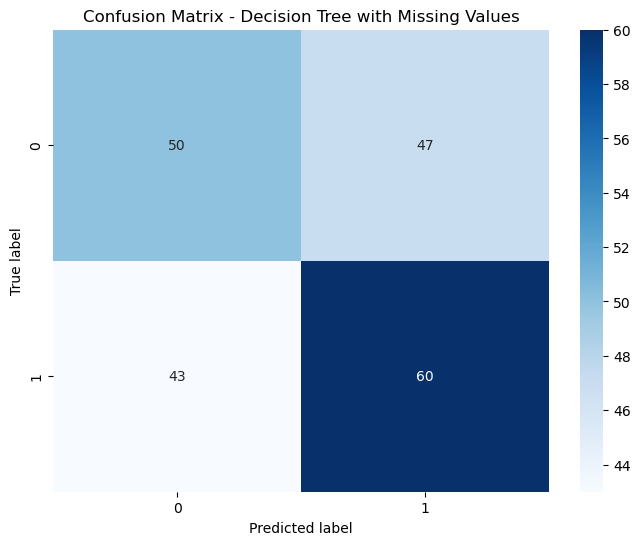


Decision Tree with Mean Imputation:
Cross-validation mean accuracy: 0.5200 (+/- 0.0457)
Training set accuracy: 1.0000
Test set accuracy: 0.5050

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51        97
           1       0.52      0.49      0.50       103

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



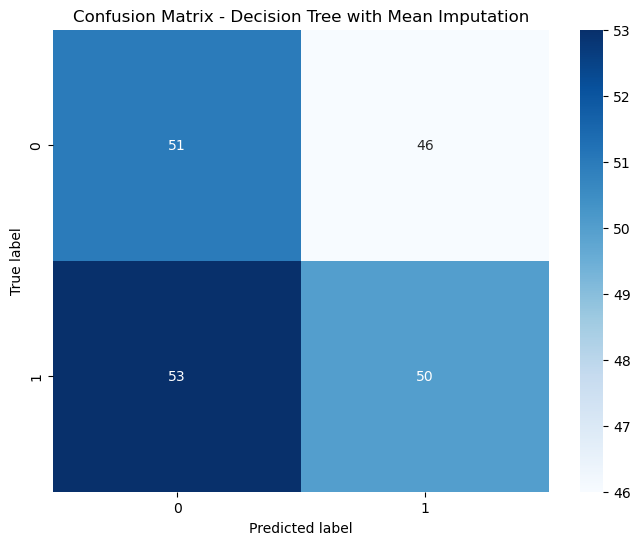

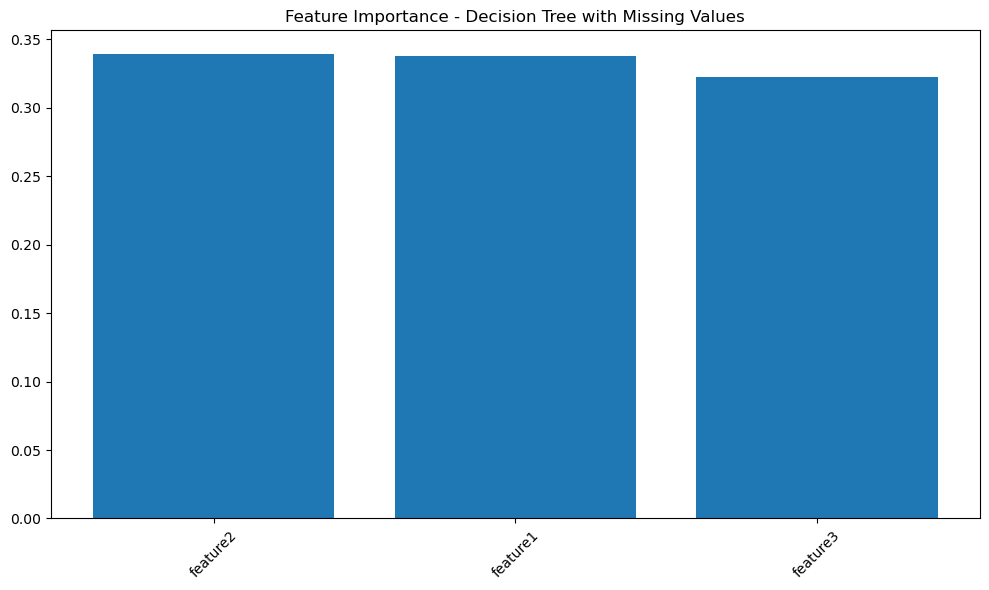

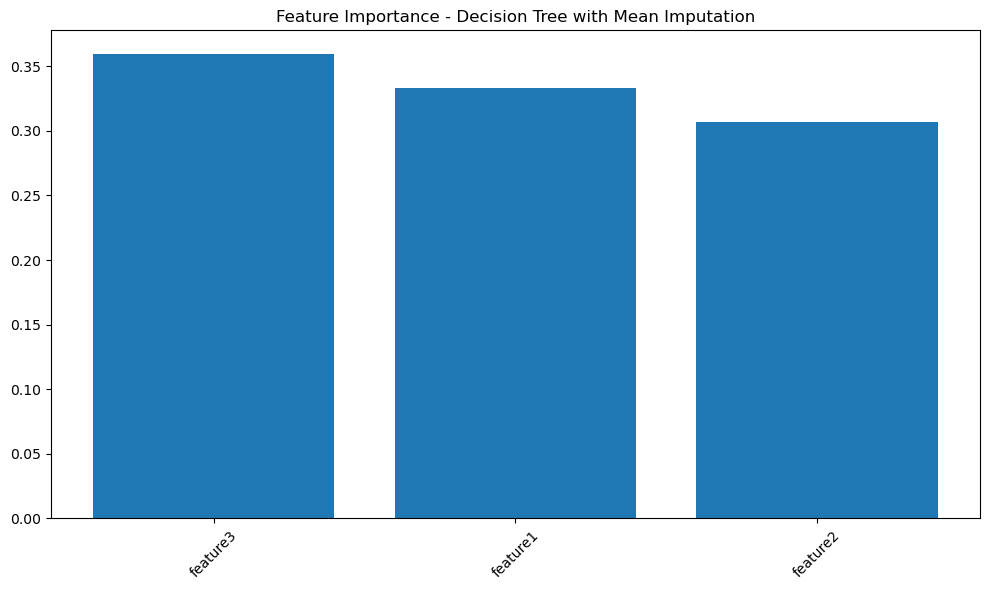


Impact of missing values on predictions:
Accuracy for samples with missing values: 0.5094
Accuracy for complete samples: 0.5646


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 创建一个包含缺失值的数据集
np.random.seed(42)
n_samples = 1000
data = {
    'feature1': np.random.rand(n_samples),
    'feature2': np.random.rand(n_samples),
    'feature3': np.random.rand(n_samples),
    'label': np.random.randint(0, 2, n_samples)
}
df = pd.DataFrame(data)

# 引入一些缺失值
for feature in ['feature1', 'feature2', 'feature3']:
    df.loc[np.random.choice(df.index, 100), feature] = np.nan

print("Missing values in the dataset:")
print(df.isnull().sum())

# 分离特征和标签
X = df[['feature1', 'feature2', 'feature3']]
y = df['label']

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义评估函数
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\n{model_name}:")
    print(f"Cross-validation mean accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print(f"Training set accuracy: {train_accuracy:.4f}")
    print(f"Test set accuracy: {test_accuracy:.4f}")
    
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 方法1：直接使用带有缺失值的数据训练决策树
dt_with_missing = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_with_missing, X_train, X_test, y_train, y_test, "Decision Tree with Missing Values")

# 方法2：使用均值填充后训练决策树
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
dt_mean_imputed = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_mean_imputed, X_train_imputed, X_test_imputed, y_train, y_test, "Decision Tree with Mean Imputation")

# 比较两种方法的特征重要性
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - {model_name}")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(dt_with_missing, X.columns, "Decision Tree with Missing Values")
plot_feature_importance(dt_mean_imputed, X.columns, "Decision Tree with Mean Imputation")

# 分析缺失值对预测的影响
def analyze_missing_impact(model, X, y):
    missing_mask = X.isnull().any(axis=1)
    X_missing = X[missing_mask]
    y_missing = y[missing_mask]
    X_complete = X[~missing_mask]
    y_complete = y[~missing_mask]
    
    missing_accuracy = model.score(X_missing, y_missing)
    complete_accuracy = model.score(X_complete, y_complete)
    
    print(f"\nImpact of missing values on predictions:")
    print(f"Accuracy for samples with missing values: {missing_accuracy:.4f}")
    print(f"Accuracy for complete samples: {complete_accuracy:.4f}")

analyze_missing_impact(dt_with_missing, X_test, y_test)